# Inject a power spectrum in random LIGO noise

This notebook is meant as a tutorial on how to use the `simulator` module within `pygwb` to generate a stochastic gravitational-wave background (SGWB), with the option of adding random Gaussian colored noise. More information about the `simulator` can be found on the documentation page [here](./_build/html/api/pygwb.simulator.html).

We start by importing some packages needed for the execution of the tutorial:

In [1]:
import numpy as np
import gwpy
import bilby
import matplotlib.pyplot as plt
from pygwb.detector import Interferometer
from pygwb.network import Network

*Note: make sure to run this notebook within an environment that has all the above packages installed.*

## Injection of a broken power-law 

For this tutorial, we consider a broken power-law signal power spectral density (PSD) to be injected in random LIGO Gaussian noise. The various steps to get to the simulated data are outlined below.

### Simulation parameters

We start by specifying the parameters that will serve as input to the simulator. Concretely, we specify the duration of each simulated segment, the number of segments, and the sampling frequency.

In [2]:
duration = 60 # duration of each segment of data (s)
N_segs = 10  # number of data segments to generate
sampling_frequency = 1024 # Hz

### The signal to inject

The `simulator` module takes a `gwpy` FrequencySeries as input for the signal PSD to be injected. We start by building a custom input signal by defining an `IntensityGW` function, which outputs the desired signal PSD in the form of a `gwpy` FrequencySeries. 

In [3]:
frequencies_x = np.linspace(0, 1000, 10000)

alpha1 = 6
alpha2 = 0
fref = 10
omegaRef = 5.e-5

def IntensityGW(freqs, omegaRef, alpha1, fref, alpha2 = 2/3):
    ''' GW Intensity function from broken power law in OmegaGW '''
    '''
    
    PARAMETERS
    freqs: np.array
        frequency array
    fref: 
        reference frequency
    omegaRef: 
        Value of OmegaGW at reference frequency
    alpha1:
        first spectral index
    alpha2:
        second spectral index
        
    RETURN
    FrequencySeries
    
    '''
    from pygwb.constants import H0
    H_theor = (3 * H0.si.value ** 2) / (10 * np.pi ** 2)
    
    fknee = fref
    
    power = np.zeros_like(freqs)
    
    power[freqs<fknee] = H_theor * omegaRef * (freqs[freqs<fknee]) ** (alpha1 -3) * fref**(-alpha1)
    power[freqs>fknee] = H_theor * omegaRef * (freqs[freqs>fknee]) ** (alpha2 - 3) * fref**(-alpha2)
    power[freqs==fknee] = H_theor * omegaRef * (fknee) ** (alpha2 -3) * fref**(-alpha2)
    
    power[0] = power[1]
    
    return gwpy.frequencyseries.FrequencySeries(power, frequencies=freqs)

Intensity_GW_inject = IntensityGW(frequencies_x, omegaRef = omegaRef, alpha1 = alpha1, fref = fref)

Below, we show the signal PSD to be injected, corresponding to the parameter choice above.

Text(0, 0.5, 'Signal PSD')

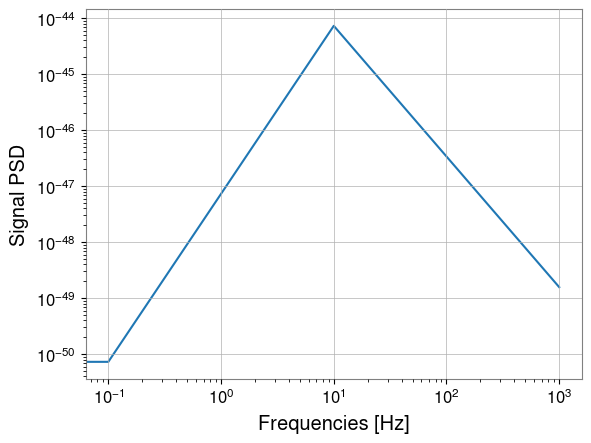

In [4]:
plt.loglog(Intensity_GW_inject.frequencies,Intensity_GW_inject.value)
plt.xlabel('Frequencies [Hz]')
plt.ylabel('Signal PSD')

Note that the above signal PSD was chosen for illustrative purposes. However, in practice, any signal PSD can be chosen to be injected, and one does not need to restrict themselves to a broken power-law.

### Initialize empty interferometers and set a noise PSD to use in the simulation

The detectors for which data with the above signal PSD need to be simulated, have to be passed to the `simulator` module. By relying on the `detector` module, we instantiate various detectors below.

In [5]:
H1 = Interferometer.get_empty_interferometer("H1") #LIGO Hanford detector
L1 = Interferometer.get_empty_interferometer("L1") #LIGO Livingston detector
V1 = Interferometer.get_empty_interferometer("V1") #Virgo detector
K = Interferometer.get_empty_interferometer("K1") #KAGRA detector
G = Interferometer.get_empty_interferometer("GEO600") # GEO600 detector

ifo_list = [H1, L1, V1, K, G]

The above detectors are `Interferometer` objects, but are based on `bilby` detectors, which have default noise PSDs saved in them, in the `power_spectral_density` attribute of the `bilby` detector. Below, we load in this noise PSD and make sure the duration and sampling frequency of the detector is set to the desired value of these parameters chosen at the start of the notebook.

In [6]:
for ifo in ifo_list:
    ifo.duration = duration
    ifo.sampling_frequency = sampling_frequency
    ifo.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(ifo.frequency_array, np.nan_to_num(ifo.power_spectral_density_array, posinf=1.e-41))

To illustrate the last few steps, we plot the PSD for the H1 detector.

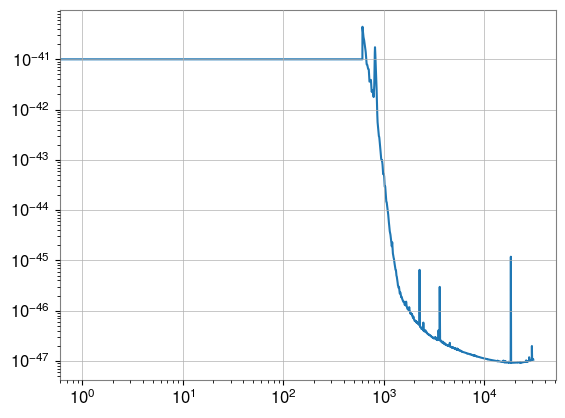

In [7]:
plt.loglog(H1.power_spectral_density.psd_array)

### Initialize a network with the interferometer list

Although the `simulator` module can be called directly, it is useful to rely on the `network` module and call the dedicated methods of that module (which calls the `simulator` behind the screens). We therefore create a network of detectors, by calling:

In [8]:
net_HLVKG = Network('HLVKG', ifo_list)

### Simulate the data in each interferometer

We are now ready to simulate the data, consisting of a signal and Gaussian noise, colored by the noise PSD saved in each of the detectors. We rely on the `network` module to simulate the data by calling the `set_interferometer_data_from_simulator` method (which uses the `simulator` module).

In [9]:
net_HLVKG.set_interferometer_data_from_simulator(N_segments=N_segs, GWB_intensity=Intensity_GW_inject, sampling_frequency=sampling_frequency)

/home/kevin.turbang/.conda/envs/pygwb_maintenance/lib/python3.9/site-packages/pygwb/network.py:220: UserWarning: User did not specify a start time. Setting start time to zero.
  warnings.warn(
2023-05-23 03:20:41.981 | INFO     | pygwb.simulator:generate_data:272 - Adding data to channel H1:SIM-STOCH_INJ
2023-05-23 03:20:42.026 | INFO     | pygwb.simulator:generate_data:272 - Adding data to channel L1:SIM-STOCH_INJ
2023-05-23 03:20:42.073 | INFO     | pygwb.simulator:generate_data:272 - Adding data to channel V1:SIM-STOCH_INJ
2023-05-23 03:20:42.119 | INFO     | pygwb.simulator:generate_data:272 - Adding data to channel K1:SIM-STOCH_INJ
2023-05-23 03:20:42.165 | INFO     | pygwb.simulator:generate_data:272 - Adding data to channel GEO600:SIM-STOCH_INJ


In order to visualize part of the simulated data, we show the first minute of data for the H1 detector.

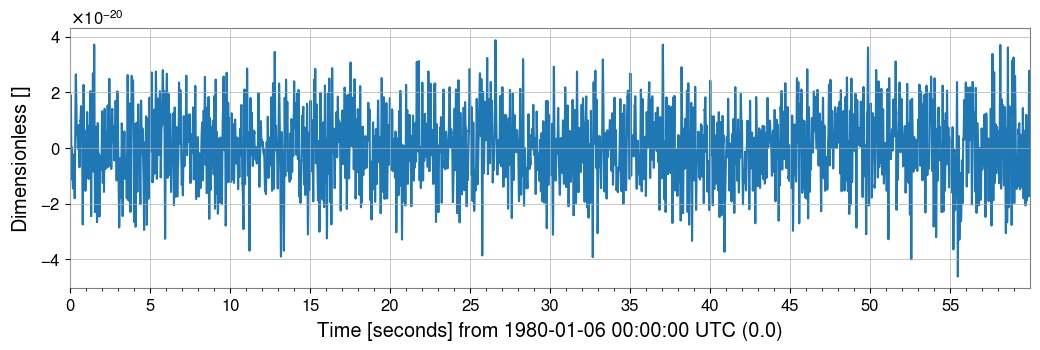

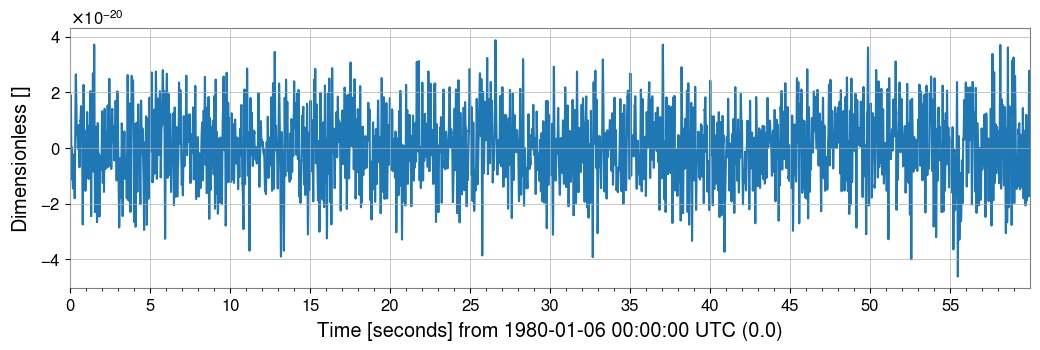

In [10]:
crop_start_time = net_HLVKG.interferometers[0].strain_data.start_time
crop_duration   = 60

# Note: we need to grab the TimeSeries from the bilby interferometer, which requires converting it to a TimeSeries
data_H_1min = net_HLVKG.interferometers[0].strain_data.to_gwpy_timeseries().crop(start = crop_start_time, end = crop_start_time + crop_duration)
data_H_1min.plot()

One could also plot the whole simulated data stream as follows.

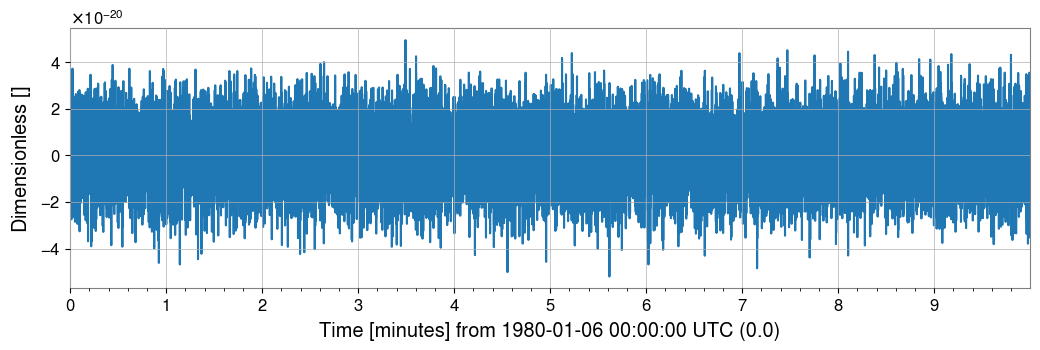

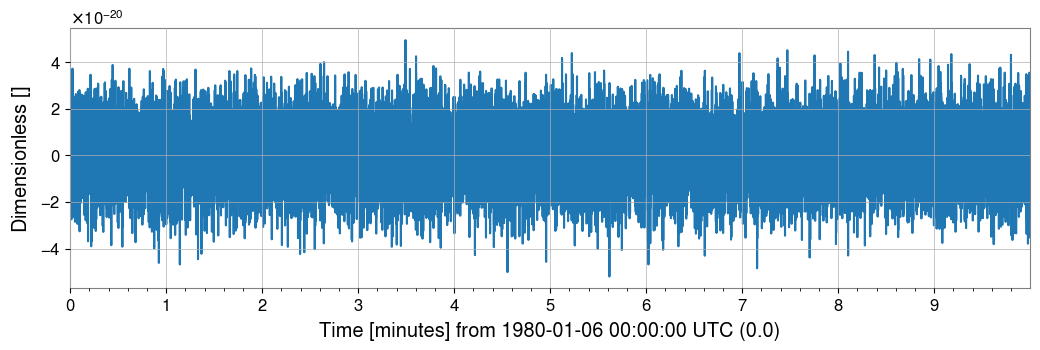

In [11]:
net_HLVKG.interferometers[0].strain_data.to_gwpy_timeseries().plot()

*Optional*: Note that one may save the data by calling `save_interferometer_data_to_file` and specifying the file format as an argument. This wraps `gwpy.TimeSeries.write()`.

In [12]:
# net_HLVKG.save_interferometer_data_to_file()

### Visualize the data PSD

To conclude this tutorial, we look at the PSD of the data (instead of the time domain data shown above). For concreteness, we look at the one minute of H1 data plotted above.

Text(0, 0.5, 'PSD')

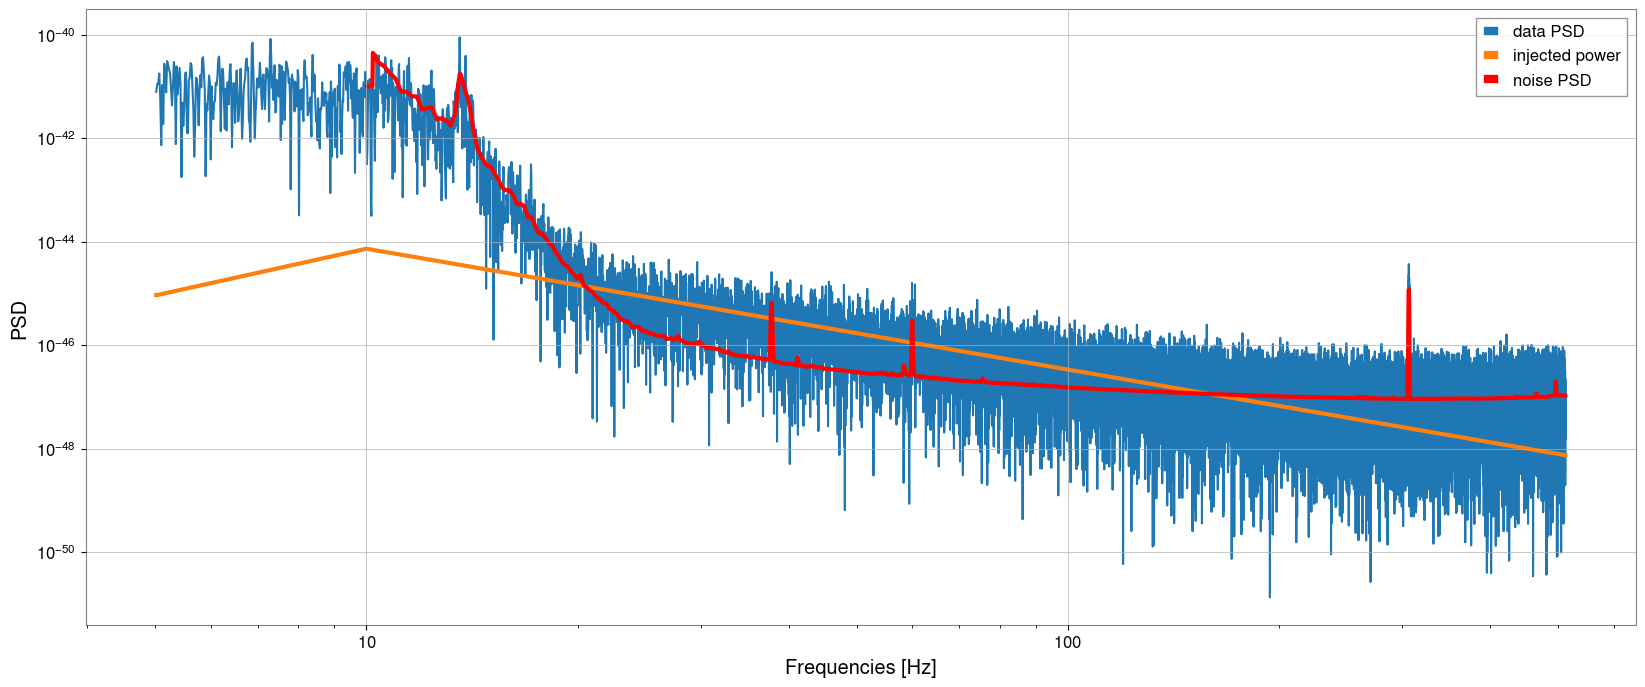

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

frequencies = data_H_1min.psd().frequencies.value

mask = frequencies>5.

ax, fig = plt.subplots(figsize = (20,8))
plt.loglog(frequencies[mask], data_H_1min.psd().value[mask], label = 'data PSD')
plt.loglog(frequencies[mask], IntensityGW(frequencies[mask],omegaRef = omegaRef, alpha1 = alpha1, fref = fref), linewidth = 3, label = 'injected power')
plt.loglog(H1.power_spectral_density.frequency_array[H1.power_spectral_density.frequency_array>10], H1.power_spectral_density.psd_array[H1.power_spectral_density.frequency_array>10], linewidth = 3, color = 'red', label = 'noise PSD')
plt.legend()
plt.xlabel('Frequencies [Hz]')
plt.ylabel('PSD')

Note that because the signal PSD amplitude was chosen fairly large, it rises above the noise PSD for a certain frequency range. This behavior is clearly also present in the data PSD (blue), illustrating the injection was performed correctly, and the signal is actually present in the data.